# Tangles on real world data
This Juypter Notebook explores the performance on Tangles on classical triplet datasets. [Examples are given in the cblearn libary.](https://github.com/dekuenstle/cblearn#datasets)

As always, we use SOE-kMeans as a baseline.

In [2]:
import sys
sys.path.append("..")
from cblearn.embedding import SOE
import cblearn.datasets as datasets
from cblearn.preprocessing import triplets_from_mostcentral
from questionnaire import Questionnaire
from triplets import triplets_to_majority_neighbour_cuts, remove_outliers, majority_neighbours_count_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from plotting import AltairPlotter
from sklearn.metrics import normalized_mutual_info_score
from estimators import OrdinalTangles
from triplets import LensMetric
import numpy as np
import altair as alt
alt.renderers.enable('altair_saver', fmts=["html", "svg"])
seed = 3

We will take a look at the so-called car dataset (see more at the CB Learn repository).  In this dataset, users select the odd-one-out from three images of cars. Triplets (A,B,C) have been put into a form, such that the following holds:

> From the three objects A, B, C, *A* is the most central object.

The transformation from cblearn assumes that the triangle inequality holds, which might already be a problem here (this could induce bias that the Tangles algorithm doesn't play into, but SOE-kMeans does). 

In [3]:
# Getting the data and cleaning the car dataset (removing outliers)
cars = datasets.fetch_car_similarity()
n_clusters = len(cars.class_name.tolist())
central_triplets = cars.triplet
central_responses = cars.response

# removing outliers
ys = cars.class_id
outliers = np.squeeze(np.where(ys == 2))
ys = ys[ys != 2]
central_triplets, central_responses = remove_outliers(central_triplets, central_responses, outliers)



triplets = triplets_from_mostcentral(central_triplets, central_responses)
# respones are just set to always be one (0 would yield the same clustering result)
responses = np.ones(triplets.shape[0]).astype(bool) 


In [4]:
q = Questionnaire.from_bool_array(triplets, responses)
q_imp = q.impute("random")

# predictions
# tangles
tangles = OrdinalTangles(agreement=8)
ys_tangles = tangles.fit_predict(q_imp.values)
tangles_maj = OrdinalTangles(agreement=7)
ys_tangles_maj = tangles_maj.fit_predict(triplets_to_majority_neighbour_cuts(triplets) > 0)
tangles_count_mat= OrdinalTangles(agreement=7)
ys_tangles_count_mat = tangles_maj.fit_predict(majority_neighbours_count_matrix(triplets, symmetric=True) > 0)
 
# soe-kmeans
soe = SOE(2, random_state=1)
kmeans = KMeans(3, random_state=1)
embedding = soe.fit_transform(triplets, responses)
ys_soe = kmeans.fit_predict(embedding)

# direct kMeans
ys_kmeans = kmeans.fit_predict(q_imp.values)

In [5]:
print(f"NMI SOE-kMeans: {normalized_mutual_info_score(ys, ys_soe)}")
print(f"NMI direct kMeans: {normalized_mutual_info_score(ys, ys_kmeans)}")
print(f"NMI Tangles: {normalized_mutual_info_score(ys, ys_tangles)}")
print(f"NMI Tangles Majority Cuts: {normalized_mutual_info_score(ys, ys_tangles_maj)}")
print(f"NMI Tangles Count Matrix: {normalized_mutual_info_score(ys, ys_tangles_count_mat)}")
print(f"#Clusters found with Tangles: {np.unique(ys_tangles).shape[0]}")
print(f"#Clusters found with majority Tangles: {np.unique(ys_tangles_maj).shape[0]}")
print(f"#Clusters found with count mat tangles: {np.unique(ys_tangles_count_mat).shape[0]}")

NMI SOE-kMeans: 0.8575493838279353
NMI direct kMeans: 0.025959646069515865
NMI Tangles: 0.014998899282559871
NMI Tangles Majority Cuts: 0.5233508262641899
NMI Tangles Count Matrix: 0.4477095669498989
#Clusters found with Tangles: 2
#Clusters found with majority Tangles: 3
#Clusters found with count mat tangles: 3


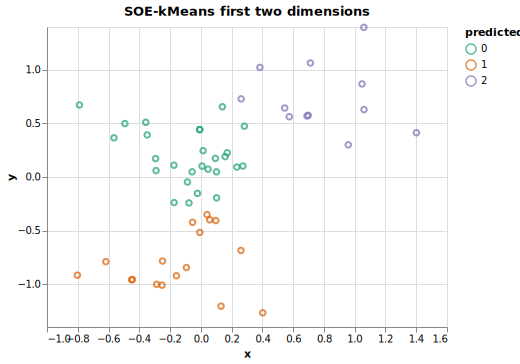

In [6]:
p = AltairPlotter()
p.assignments(embedding[:, 0:2], ys_soe).properties(title="SOE-kMeans first two dimensions")

The problem that we are faced with Tangles, is that we do not have any suitable imputation in this case. As every entry that we get is only a 1, if we do k-NN imputation, we will end up with 1s in every part of the array. 

If we do random imputation, we will end up with bad performance (as has been observed numerous times). 

This could be a serious challenge and goes against the models we have imagined so far (Triplets as mindsets, similar objects answer similarly).

To iterate on this problem, we have investigated a new cut-finding method in the next Jupyter notebook (majority cuts). The results have also been added to this notebook, but seem to be subpar (only 0.5 of the NMI that SOE-kMeans achieves).

## Boosted Tangles
We know that essentially, Tangles is a cut boosting framework. This means that Tangles is especially adept at filtering the cuts it needs and throwing away useless cuts (this can be seen in Solveigs experiments as well, where we can throw hundreds of useful cuts at Tangles and it doesn't decrease performance).
So, the question stands, why not just use a plethora of cuts for Tangles? We can run the same SOE multiple times, or aggregate cuts from different sources.

## Combining with majority cuts

In [19]:
# predictions
tangles_boost = OrdinalTangles(agreement=8)
maj_cuts = triplets_to_majority_neighbour_cuts(triplets, radius=1.8)
 
# soe-kmeans
soe = SOE(2, random_state=1)
kmeans = KMeans(4, random_state=1)
embedding = soe.fit_transform(triplets, responses)
q = Questionnaire.from_metric(embedding)

ys_tangles_boost = tangles_boost.fit_predict(np.hstack((maj_cuts, q.values)))
print(f"NMI boosted Tangles: {normalized_mutual_info_score(ys, ys_tangles_boost)} ({np.unique(ys_tangles_boost).shape[0]} clusters)")

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 56/56 [00:00<00:00, 1393.69it/s]


NMI boosted Tangles: 0.9345031208029516 (3 clusters)


In [21]:
cut_list = []
soe_kmeans_nmi= []
init_random = 0

def add_to_cut_list(embedding_model, iterations, cut_list, name):
    for i in range(iterations):
        embedder = embedding_model(2, random_state=init_random + i)
        embedding = embedder.fit_transform(triplets, responses)
        q = Questionnaire.from_metric(embedding, verbose=False, density=1)
        cut_list.append(q.values)
        ys_soe = kmeans.fit_predict(embedding)
        # p.assignments(embedding, ys_soe).display()
        soe_kmeans_nmi.append(normalized_mutual_info_score(ys, ys_soe))
    print(f"Embedder NMI average: {np.mean(soe_kmeans_nmi)} std: {np.std(soe_kmeans_nmi)}") 

add_to_cut_list(SOE, 1, cut_list, "SOE")

Embedder NMI average: 0.6511459947152095 std: 0.0


In [22]:
# predictions
tangles_boost = OrdinalTangles(agreement=10)

ys_tangles_boost = tangles_boost.fit_predict(np.hstack((cut_list)))
print(f"NMI boosted Tangles: {normalized_mutual_info_score(ys, ys_tangles_boost)} ({np.unique(ys_tangles_boost).shape[0]} clusters)")
np.hstack(cut_list).shape

NMI boosted Tangles: 0.9345031208029514 (3 clusters)


(56, 1540)

We can see that the performance doesn't differ when using low density, 50 SOE-kMeans instances vs high density, 1 SOE-kMeans instance.

## Boosted fill
Next up, we try to kind of "combine" two questionnaires: The ones that we can get raw from the data, and the ones that we get when we do an SOE-embedding followed by clustering.

The hope is that we can keep the original triplets and the ones by SOE act as a kind of imputation.

In [141]:
q = Questionnaire.from_bool_array(triplets, responses)
soe = SOE(2, random_state=None)
embedding = soe.fit_transform(triplets, responses)
q_emb = Questionnaire.from_metric(embedding)
q_filled = q.fill_with(q_emb)

tangles = OrdinalTangles(agreement=8)
ys_tangles = tangles.fit_predict(q_emb.values)
print(f"NMI Fill-Boosted Tangles: {normalized_mutual_info_score(ys, ys_tangles)} ({np.unique(ys_tangles).shape[0]}) ")

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 56/56 [00:00<00:00, 1359.06it/s]

NMI Fill-Boosted Tangles: 0.9345031208029516 (3) 


In [91]:
# trying to keep high quality columns
qual = np.where((q.values != -1).sum(axis=0) > 10)[0]
qv_qual = q.values[:, qual]
l_qual = np.array(q.labels)[qual]
q_emb_qual = q_emb.values[:, qual]
l_emb_qual = np.array(q_emb.labels)[qual]
q_qual = Questionnaire(qv_qual, l_qual.tolist())
q_emb_qual = Questionnaire(q_emb_qual, l_emb_qual.tolist())

q_filled_qual = q_qual.fill_with(q_emb_qual)

tangles = OrdinalTangles(agreement=8)
ys_tangles = tangles.fit_predict(q_filled_qual.values)
print(f"NMI Fill-Boosted Tangles high quality: {normalized_mutual_info_score(ys, ys_tangles)} ({np.unique(ys_tangles).shape[0]}) ")

NMI Fill-Boosted Tangles high quality: 0.6576752231395959 (3) 


Bad.

# Iterative fill method
We try the method proposed by Solveig.

In [57]:
q = Questionnaire.from_bool_array(triplets, responses)
q_imp = q.impute("1000-fill")
tangles = OrdinalTangles(agreement=8)
ys_tangles = tangles.fit_predict(q_imp.values)
print(f"NMI Tangles with iterative fill: {normalized_mutual_info_score(ys, ys_tangles)} ({np.unique(ys_tangles).size})")

NMI Tangles with iterative fill: 0.09876115887141927 (3)


# With Lens Depth functions

In [58]:
q = Questionnaire.from_most_central_triplets(central_triplets, central_responses, randomize_ties=False, normalize=False)
tangles = OrdinalTangles(9)
ys_tangles = tangles.fit_predict(q.values)
print(f"NMI Tangles: {normalized_mutual_info_score(ys, ys_tangles)} ({np.unique(ys_tangles).shape[0]})")

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 56/56 [00:00<00:00, 1376.26it/s]

NMI Tangles: 0.7386005399007414 (3)


In [15]:
dists = LensMetric()
cuts = dists.pairwise_triplets(central_triplets, central_responses, normalize=True) < (4/58)
tangles = OrdinalTangles(8)
ys_tangles = tangles.fit_predict(cuts.T)
print(f"NMI Tangles: {normalized_mutual_info_score(ys, ys_tangles)} ({np.unique(ys_tangles).shape[0]})")

NMI Tangles: 0.08132384645664063 (2)


Eeeeeeeh.

# Annealing majority neighbour cuts
As an idea, the Tangles algorithm needs to have a wide variety of cuts in a kind of "hierarchical" way (this is also how the clusters are used). We might want to support this by adding multiple cuts of the majority cuts next to each other and cluster on that.

In [235]:
tangles_maj = OrdinalTangles(agreement=7)
cuts = []
n = ys.shape[0]
for r in [1.5]:
    cut = triplets_to_majority_neighbour_cuts(triplets, radius=r)
    cuts.append(cut)
ys_tangles_maj = tangles_maj.fit_predict(np.concatenate(cuts, axis=1))
print(f"NMI Tangles Majority Cuts: {normalized_mutual_info_score(ys, ys_tangles_maj)} ({np.unique(ys_tangles_maj).shape[0]})")

NMI Tangles Majority Cuts: 0.3015555415405588 (3)
